In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
for rows in session.query(station).limit(20).all():
    print(vars(rows))

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001E90191BDC0>, 'elevation': 3.0, 'station': 'USC00519397', 'name': 'WAIKIKI 717.2, HI US', 'id': 1, 'longitude': -157.8168, 'latitude': 21.2716}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001E90191B730>, 'elevation': 14.6, 'station': 'USC00513117', 'name': 'KANEOHE 838.1, HI US', 'id': 2, 'longitude': -157.8015, 'latitude': 21.4234}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001E90191B040>, 'elevation': 7.0, 'station': 'USC00514830', 'name': 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 'id': 3, 'longitude': -157.8374, 'latitude': 21.5213}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001E90191BA60>, 'elevation': 11.9, 'station': 'USC00517948', 'name': 'PEARL CITY, HI US', 'id': 4, 'longitude': -157.9751, 'latitude': 21.3934}
{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState object at 0x000001E90191BB20>, 'elevation': 

# Exploratory Climate Analysis

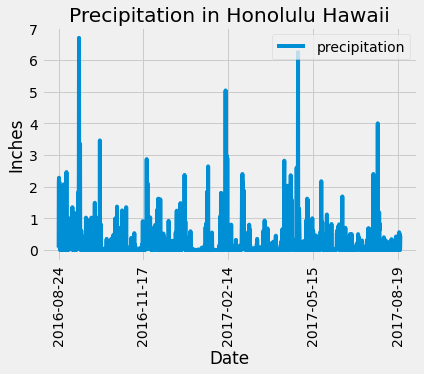

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_data_pt = session.query(measurement.date, measurement.station).\
order_by(measurement.date.desc()).limit(20).all()
#last_data_pt
# Perform a query to retrieve the data and precipitation scores
date_end = dt.datetime(2017, 8, 23)
date_start = dt.datetime(2016, 8, 23)
sel = [measurement.date, measurement.prcp]
prcp_results = session.query(*sel).\
    filter(measurement.date <= date_end).\
    filter(measurement.date >= date_start).\
    order_by(measurement.date).all()
    #filter(measurement.station == 'USC00519397').all()
#prcp_results
# # Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_results, columns=['date', 'prcp'])
prcp_no_null_df = prcp_df.dropna()
prcp_no_null_df.set_index('date', inplace=True)
# #prcp_no_null_df
# # # Sort the dataframe by date(not necessary, already sorted in query)

# # # Use Pandas Plotting with Matplotlib to plot the data
prcp_no_null_df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation in Honolulu Hawaii")
plt.legend(['precipitation'], loc= 'upper right')
plt.show()


In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_no_null_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [15]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.station)).all()

[(9)]

In [16]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
session.query(measurement.station, func.count(measurement.station)).\
group_by(measurement.station).\
order_by(func.count(measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
session.query(measurement.station, \
              func.min(measurement.tobs), \
              func.max(measurement.tobs), \
              func.avg(measurement.tobs)).\
filter(measurement.station == 'USC00519281').all()

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

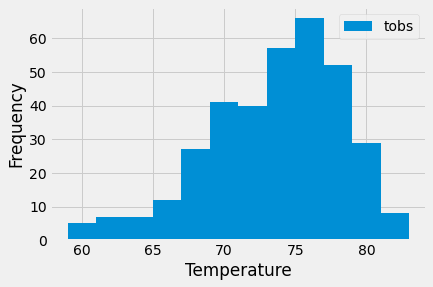

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel = [measurement.date, measurement.tobs]
tobs_results = session.query(*sel).\
    filter(measurement.date <= date_end).\
    filter(measurement.date >= date_start).\
    filter(measurement.station == 'USC00519281').all()

#Plot as histogram
tobs_pd= pd.DataFrame(tobs_results)
tobs_pd.plot.hist(bins=12)
plt.xlabel("Temperature")

## Bonus Challenge Assignment

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
